In [3]:
import os
import re
import requests
import aiohttp
import pandas as pd

from operator import itemgetter
from tqdm import tqdm

from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from PIL import Image
from duckduckgo_search import DDGS

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

## Make Index

In [2]:
df = pd.read_csv("../data/raw/food-dataset-ru.csv")
df.head()

,Название,Рецепт,Ингредиенты,Пищевая ценность,Тип кухни,Время приготовления,Ссылка,Класс
0,Завтрак для ленивых,"В широкую миску выложить творог, добавить яйцо...","Куриное яйцо: 1 штука, Мягкий творог: 200 г, П...","Калорий 87 ккал, Белки 8 грамм, Жиры 2 грамм, ...",Русская кухня,15 минут,https://eda.ru/recepty/zavtraki/zavtrak-dlja-l...,Завтрак
1,Гречневый завтрак,"Гречку промыть, залить 2 стаканами кипятка, по...","Гречневая крупа: 1 стакан, Рубленая петрушка: ...","Калорий 284 ккал, Белки 6 грамм, Жиры 11 грамм...",Русская кухня,1 час 20 минут,https://eda.ru/recepty/zavtraki/grechnevij-zav...,Завтрак
2,Завтрак детства,Морковь и зеленое яблоко натереть на средней т...,"Морковь: 1 штука, Яблоко: 1 штука, Апельсины: ...","Калорий 623 ккал, Белки 13 грамм, Жиры 22 грам...",Русская кухня,5 минут,https://eda.ru/recepty/zavtraki/zavtrak-detstv...,Завтрак
3,Полный английский завтрак,"Разогреть духовку до 180 градусов, а сковороду...","Куриное яйцо: 2 штуки, Свиные сосиски: 2 штуки...","Калорий 907 ккал, Белки 26 грамм, Жиры 75 грам...",Британская кухня,30 минут,https://eda.ru/recepty/zavtraki/polnyy-angliys...,Завтрак
4,Французские гренки к завтраку,Смешать яйцо с молоком. Посолить. Обмакнуть ку...,"Батон: 3 куска, Молоко: 2 столовые ложки, Кури...","Калорий 519 ккал, Белки 16 грамм, Жиры 29 грам...",Французская кухня,10 минут,https://eda.ru/recepty/zavtraki/francuzskie-gr...,Завтрак


In [12]:
content_columns = ["Название", "Ингредиенты", "Пищевая ценность", "Тип кухни", "Время приготовления", "Класс"]
metadata_columns = ["Название", "Рецепт", "Ингредиенты", "Пищевая ценность", "Тип кухни", "Время приготовления", "Ссылка", "Класс"]

loader = CSVLoader(
    file_path="../data/raw/food-dataset-ru.csv",
    encoding="utf-8",
    csv_args={
        "delimiter": ",",
        "quotechar": '"',
    },
    content_columns=content_columns,
    metadata_columns=metadata_columns
)

data_documents = loader.load()

In [13]:
print(data_documents[0])

page_content='Название: Завтрак для ленивых
Ингредиенты: Куриное яйцо: 1 штука, Мягкий творог: 200 г, Пшеничная мука: 30 г, Сахар: по вкусу, Соль: по вкусу
Пищевая ценность: Калорий 87 ккал, Белки 8 грамм, Жиры 2 грамм, Углеводы 8 грамм
Тип кухни: Русская кухня
Время приготовления: 15 минут
Класс: Завтрак' metadata={'source': '../data/raw/food-dataset-ru.csv', 'row': 0, 'Название': 'Завтрак для ленивых', 'Рецепт': 'В широкую миску выложить творог, добавить яйцо, сахар и муку и вилкой смешать до однородной консистенции. Если масса получилась слишком липкой, добавить еще муки, но не больше половины столовой ложки. Посыпать стол небольшим количеством муки и выложить творожную массу. Разделить на две равные части и из каждой скатать колбаски одинаковой толщины. Острым ножом нарезать колбаски на небольшие одинаковые кусочки. При желании можно слегка приплюснуть затем каждый кусочек и придать ему округлую форму. В небольшой кастрюле довести до кипения воду. Аккуратно один за другим опустить 

In [2]:
embeddings = HuggingFaceEmbeddings(
    model_name="sergeyzh/LaBSE-ru-turbo"
)

d:\Repositories\llm-food-assistant\env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [15]:
# Создаём векторное хранилище
db = None
with tqdm(total=len(data_documents), desc="Ingesting documents") as pbar:
    for d in data_documents:
        if db:
            db.add_documents([d])
        else:
            db = FAISS.from_documents([d], embeddings)
        pbar.update(1)  

Ingesting documents: 100%|██████████| 37638/37638 [2:47:35<00:00,  3.74it/s]  


In [18]:
db.save_local("food_faiss_index")

In [3]:
db = FAISS.load_local(
    folder_path="food_faiss_index",
    embeddings=embeddings,
    allow_dangerous_deserialization=True
)

In [21]:
res_search = db.similarity_search(query="Придумай пиццу из сыра и бекона", k=3)

for res in res_search:
    print(res.page_content)
    print("\n", end='')

Название: Пицца с беконом и овощами
Ингредиенты: Сыр: 200 г, Тесто для пиццы: 300 г, Бекон: 200 г, Репчатый лук: 1 головка, Помидоры: 150 г, Свежая спаржа: 50 г, Лук-порей: 150 г, Морковь: 1 штука, Сливочное масло: 50 г, Молоко: 200 мл, Сметана: 100 г, Соль: по вкусу, Куриное яйцо: 3 штуки, Молотый черный перец: по вкусу, Зелень: 50 г
Пищевая ценность: Калорий 919 ккал, Белки 40 грамм, Жиры 61 грамм, Углеводы 53 грамм
Тип кухни: Итальянская кухня
Время приготовления: 1 час  30 минут
Класс: Паста или пицца

Название: Пицца «Четыре сыра»
Ингредиенты: Тесто для пиццы: 500 г, Сыр рикотта: 60 г, Сыр моцарелла: 50 г, Сыр горгонзола: 50 г, Сыр пармезан: 25 г, Полента: по вкусу
Пищевая ценность: Калорий 925 ккал, Белки 37 грамм, Жиры 29 грамм, Углеводы 129 грамм
Тип кухни: Итальянская кухня
Время приготовления: 30 минут
Класс: Паста или пицца

Название: Пицца с копченым сыром и боттаргой
Ингредиенты: Тесто для пиццы: 1 штука, Помидоры пелати: 1 банка, Чеснок: 2 зубчика, Лук-шалот: 1 головка, О

## Help functions

In [4]:
def clean_input(input_string: str) -> str:
    """Удаляет лишние пробелы и символы для экономия токенов

    Args:
        input_string (str): входной текст

    Returns:
        str: отфильтрованный текст
    """
    clean_string = re.sub(r'(^|[^\w])[\?!]+', r'\1', input_string)

    return clean_string


def format_docs(docs) -> str:
    """Форматирование документов в единную строку

    Args:
        docs: Документы от ретривера

    Returns:
        (str): Строка со всеми документами 
    """
    return "\n\n".join([d.page_content for d in docs])


def format_docs_with_links(docs) -> str:
    """Форматирование документов в единную строку и добвляет метаданные

    Args:
        docs: Документы от ретривера

    Returns:
        (str): Строка со всеми документами 
    """
    func = lambda d: f"{d.page_content}\nПодробнее:{d.metadata['Ссылка']}"
    return "\n\n".join([func(d) for d in docs])


def search_image(dict_input: dict) -> dict:
    """Поиск изображения по запросу

    Args:
        dict_input (dict): Входная цепочка

    Returns:
        dict: Цепочка с изображением и мета данными
    """
    try:
        urls_images = DDGS().images(
            keywords=dict_input["query"],
            region='ru-ru',
            safesearch='off',
            type_image="photo",
            max_results=1
            )

        image_link = urls_images[0]['image']
        url = urls_images[0]['url']
        img = Image.open(requests.get(image_link, stream=True).raw)
    except Exception:
        img, image_link, url = None, None, None

    result_dict = {
        "output": img,
        "image": image_link,
        "url": url,
        "task": "Search Image"
        }

    return result_dict

## Prompts

In [ ]:
PROMPT_CLASSIFIER = """Given the user question below, classify it as either being about
`recommended`, `generate`, `image food`, `about me` or `other`.
Do not respond with more than one word.

<question>
{input}
</question>

Classification:"""

PROMPT_ASSISTANT = """You are a conversational AI assistant integrated with LangChain, capable of various tasks.

If asked about your functions, here is how you work:
- Recipe Recommendation: You analyze a dish description and suggest a single recipe along.
- Dish Generation: You create new dishes based on a given description and query, coming up with a unique name, ingredients, and a brief cooking guide.
- Food Image Search: You can find relevant food images based on user input.

Query: {query} 

Answer:"""

PROMPT_RECOMMENDER = """You are an expert chef, recommend only one recipe from the descripition.
Return the recipe text as in the description, link аnd listed ingredients with emoji.

<descripition>
{descripition}
</descripition>

Query: {query}

Answer:"""

PROMPT_GENERATER = """You are an expert chef, use the description,
query and come up with your edible dish:
- come up with a new name
- list the ingredients with the emoji
- briefly explain how to cook

<descripition>
{descripition}
</descripition>

Query: {query}

Answer:"""

PROMPT_SEARCH = """You are an internet search expert,
fix the user query and return only the name of the dish him need to find.

Query: {query}

Summary query:"""

## Agent

In [5]:
class AgentSystem:
    """LLM система агентов
    """
    def __init__(self, llm, retriever):
        self.llm = llm
        self.retriever = retriever

        self.assistant_chain = self.get_assistant_chain()
        self.recommender_chain = self.get_recommender_chain()
        self.generater_chain = self.get_generater_chain()
        self.search_chain = self.get_search_chain()

        self.full_chain = self.initial_chain()
    
    def invoke(self, query: str):
        """Вызов цепочки

        Args:
            query (str): Запрос пользователя

        Returns:
            dict: Результат системы цепочек
        """
        return self.full_chain.invoke(query)

    def initial_chain(self):
        """Создание цепочки агентов

        Returns:
            full_chain: Итоговая цепочка системы
        """
        classifier_chain = (
            clean_input
            | PromptTemplate.from_template(PROMPT_CLASSIFIER)
            | self.llm
            | StrOutputParser()
        )

        full_chain = (
            {"input": RunnablePassthrough(), "topic": classifier_chain}
            | RunnableLambda(self.route_chain)
        )

        return full_chain

    def get_assistant_chain(self):
        """Создание цепочки для для ассистента
        """
        assistant_chain = (
            PromptTemplate.from_template(PROMPT_ASSISTANT)
            | self.llm
            | {"output": lambda x: x.content, "task": lambda x: "About Me"}
        )

        return assistant_chain

    def get_recommender_chain(self):
        """Создание цепочки для рекомендации блюда по запросу пользователя
        """
        recommender_chain = (
            {
                "descripition": itemgetter("input") | self.retriever | format_docs_with_links,
                "query": itemgetter("input")
            }
            | PromptTemplate.from_template(PROMPT_RECOMMENDER)
            | self.llm
            | {"output": lambda x: x.content, "task": lambda x: "Recommend"}
        )

        return recommender_chain

    def get_generater_chain(self):
        """Создание цепочки для генерации идеи для нового блюда по запросу пользователя
        """
        generater_chain = (
            {
                "descripition": itemgetter("input")| self.retriever | format_docs,
                "query": itemgetter("input")
            }
            | PromptTemplate.from_template(PROMPT_GENERATER)
            | self.llm
            | {"output": lambda x: x.content, "task": lambda x: "Generate"}
        )

        return generater_chain

    def get_search_chain(self):
        """Создание цепочки для поиска изображения блюда с помощью DuckDuckGo Search
        """
        search_chain = (
            {"query": RunnablePassthrough()}
            | PromptTemplate.from_template(PROMPT_SEARCH)
            | self.llm
            | {"query": lambda x: x.content}
            | search_image
        )

        return search_chain

    def route_chain(self, dict_chain):
        """Маршрутизация запроса пользователя по цепочкам
        """
        info_class = dict_chain["topic"].lower()

        if "about me" in info_class:
            return self.assistant_chain
        elif "recommended" in info_class:
            return self.recommender_chain
        elif "generate" in info_class:
            return self.generater_chain
        elif "image food" in info_class:
            return self.search_chain
        
        other_task = {
            "output": "К сожалению, я не понял запроса.",
            "task": "Unknown"
        }
        
        return other_task

In [6]:
llm = ChatOpenAI(
    base_url="https://api.groq.com/openai/v1",
    model="llama-3.1-70b-versatile",
    api_key=os.environ.get("OPENAI_API_KEY"),
    temperature=0.0
)

embeddings = HuggingFaceEmbeddings(
    model_name="sergeyzh/LaBSE-ru-turbo"
)

db = FAISS.load_local(
    folder_path="food_faiss_index",
    embeddings=embeddings,
    allow_dangerous_deserialization=True
)

retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 3}
)

d:\Repositories\llm-food-assistant\env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [7]:
agent_executor = AgentSystem(llm=llm, retriever=retriever)

## Test examples

In [8]:
result = agent_executor.invoke("Посоветуй коктейль для диеты?)")
print(result['output'])

Я рекомендую "Бодрящий коктейль" для диеты. Этот коктейль имеет очень низкую калорийность (5 ккал) и не содержит жиров и белков.

**Бодрящий коктейль**

Эстрагон: 6 столовых ложек 🌿
Минеральная вода: 1 л 💧
Свежевыжатый мандариновый сок: 50 г 🍊
Базилик: 15 г 🌿

Подробнее: https://eda.ru/recepty/napitki/bodrjashhij-koktejl-39341


In [9]:
result = agent_executor.invoke("Придумай пиццу из курицы, ананасов и сыра!")
print(result['output'])

Название: "Тропическая куриная пицца"

Ингредиенты:
- Тесто для пиццы: 500 г 🍞
- Куриное филе: 300 г 🍗
- Ананас: 200 г 🍍
- Сыр моцарелла: 250 г 🧀
- Растительное масло: 1 столовая ложка 💧
- Соль: по вкусу ❗️
- Молотый черный перец: по вкусу ❗️
- Свежий базилик: 2 веточки 🌿

Описание: Эта пицца сочетает в себе сочную курицу, сладкий ананас и плавящийся сыр. Тесто для пиццы можно приготовить заранее или использовать готовое.

Приготовление:
1. Разогрейте духовку до 220°C.
2. Раскатайте тесто для пиццы и выложите его на противень.
3. Смажьте тесто растительным маслом и посыпьте солью и перцем.
4. Выложите куриное филе на тесто, затем добавьте ананас и сыр.
5. Выпекайте пиццу в духовке в течение 15-20 минут, пока тесто не станет золотистым и сыр не расплавится.
6. Украсьте пиццу свежим базиликом и подавайте горячей.


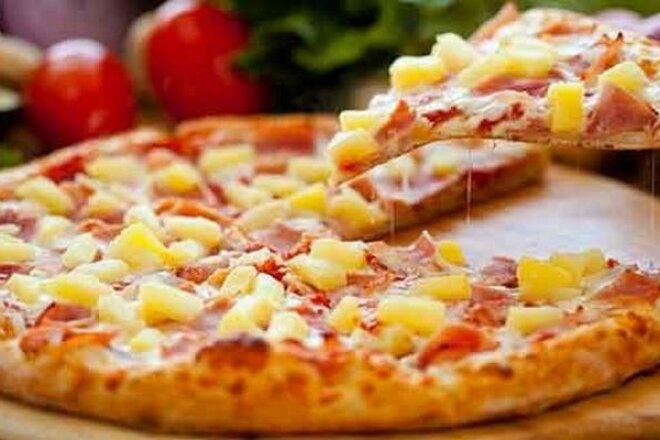

In [10]:
result = agent_executor.invoke("Как выглядит пицца из курицы, ананасов и сыра")
result['output']

In [12]:
result = agent_executor.invoke("Как выглядит флаг Канады?")
result['output']

'К сожалению, я не понял запроса.'

## Spech2Text

In [1]:
def spech2text(audio_file):
    API_URL = "https://api-inference.huggingface.co/models/openai/whisper-large-v3-turbo"
    headers = {"Authorization": f'Bearer {os.environ["HF_TOKEN"]}'}

    response = requests.post(API_URL, headers=headers, data=audio_file)
    return response.json()

In [2]:
async def spech2text(audio_file):
    API_URL = "https://api-inference.huggingface.co/models/openai/whisper-large-v3-turbo"
    headers = {"Authorization": f'Bearer {os.environ["HF_TOKEN"]}'}

    async with aiohttp.ClientSession() as session:
        async with session.post(API_URL, headers=headers, data=audio_file) as response:
            return await response.json()

In [7]:
with open("./test_audio.ogg", "rb") as f:
    text = await spech2text(f.read())
    print(text)

{'text': ' Сгенерируем мне блюда из курицы и свинины.'}
